<a href="https://colab.research.google.com/github/emailmenojunk/datascience/blob/main/Student_MLE_MiniProject_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
!pip install scikeras
!pip install --upgrade scikit-learn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from sklearn.pipeline import Pipeline

In [43]:
DATA_PATH = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'

# Download the dataset and load it into a pandas DataFrame
df = pd.read_csv(DATA_PATH, header=None)

In [44]:
# Display the first few rows of the DataFrame
df.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [45]:
#how rows and columns in the dataset
df.shape
#How are NULL values represented?
#df.isnull().sum()




(32561, 15)

In [46]:
#What's the percentage of positive cases in the dataset where annual iocome is >50K
df[14].value_counts(normalize=True)

,proportion
14,
<=50K,0.75919
>50K,0.24081


In [47]:
#drop null valuds
df.dropna()
df.shape


(32561, 15)

In [48]:
#Lets name the columns of this dataset
df.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']

In [49]:
# Use Scikit-Learn's LabelEncoder to convert the income column with a data type
# string to a binary variable.
le = LabelEncoder()
# Fit and transform the 'income' column
df['income_encoded'] = le.fit_transform(df['income'])

# Display the first few rows with the new encoded column
display(df[['income', 'income_encoded']].head())

,income,income_encoded
0,<=50K,0
1,<=50K,0
2,<=50K,0
3,<=50K,0
4,<=50K,0


In [50]:
##Split dataset into training and test sets. Exclude income column
X = df.drop(['income', 'income_encoded'], axis=1)
y = df['income_encoded']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (26048, 14)
Shape of X_test: (6513, 14)
Shape of y_train: (26048,)
Shape of y_test: (6513,)


In [51]:
# Use Scikit-Learn's roc_auc_score to calculate the AUC score for a method that
# always predicts the majority class.
majority_class = y_train.value_counts().idxmax()

# Create an array of predictions for the test set, always predicting the majority class
baseline_predictions = np.full(y_test.shape, majority_class)

# Calculate the AUC score
baseline_auc = roc_auc_score(y_test, baseline_predictions)

print(f"AUC score for majority class prediction: {baseline_auc}")

AUC score for majority class prediction: 0.5


In [52]:
# Identify categorical columns
categorical_features = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']

# Identify numerical columns
# These are the columns not in the categorical_features list, excluding the target columns
numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
# Ensure no categorical features are in numerical_features (in case dtypes weren't correctly inferred)
numerical_features = [col for col in numerical_features if col not in categorical_features]


# Create a ColumnTransformer to apply OneHotEncoder to categorical features and MinMaxScaler to numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', MinMaxScaler(), numerical_features) # Add MinMaxScaler for numerical features
    ]
)

# Apply the ColumnTransformer to the training data
X_train_processed = preprocessor.fit_transform(X_train)

# Display the shape of the processed training data
print("Shape of processed X_train:", X_train_processed.shape)

Shape of processed X_train: (26048, 108)


In [53]:
# How many columns will the dataframe have after these columns transformations are applied?

X_train_processed.shape

(26048, 108)

In [54]:
# Define the Keras model
def keras_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu')) # Add a dense layer with ReLU activation
    model.add(Dense(1, activation='sigmoid')) # Add an output layer with sigmoid activation for binary classification
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # Compile the model
    return model # Return the compiled model

In [55]:
# Create a Keras classifier
model = KerasClassifier(model=keras_model, input_dim=X_train_processed.shape[1], epochs=10, batch_size=32, verbose=1)

In [56]:
# Create the scikit-learn pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

In [57]:
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
814/814 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7937 - loss: 0.4271
Epoch 2/10
814/814 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8441 - loss: 0.3353
Epoch 3/10
814/814 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8466 - loss: 0.3291
Epoch 4/10
814/814 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8453 - loss: 0.3239
Epoch 5/10
814/814 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8536 - loss: 0.3165
Epoch 6/10
814/814 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8551 - loss: 0.3111
Epoch 7/10
814/814 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8559 - loss: 0.3117
Epoch 8/10
814/814 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8593 - loss: 0.3058
Epoch 9/10
814/814 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8574 - loss: 0.3059
Epoch 10/10
814/814 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8586 - loss: 0.3084


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [58]:
# Calculate the AUC score of your model on the test data.
predictions = pipeline.predict_proba(X_test)[:, 1]
score_auc = roc_auc_score(y_test, predictions)

print(f"AUC score - test data: {score_auc}")

204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
AUC score - test data: 0.9081240544356548


In [59]:
#compare baseline_auc and score_auc , which is better?

print(f"AUC score for majority class prediction: {baseline_auc}")
print(f"AUC score - test data: {score_auc}")


AUC score for majority class prediction: 0.5
AUC score - test data: 0.9081240544356548


AUC score of test data is better

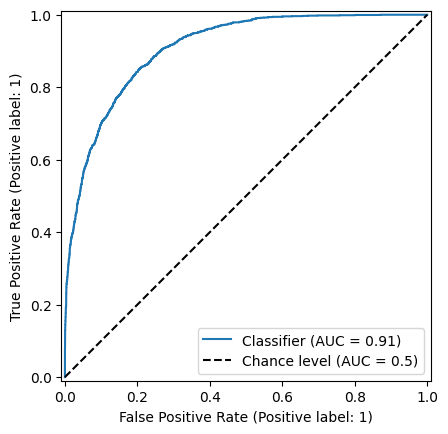

In [60]:
from sklearn.metrics import RocCurveDisplay

# Generate an ROC curve for your model.
RocCurveDisplay.from_predictions(y_test, predictions, plot_chance_level=True)